# Import Packages and Reading of Data

In [20]:
pip install bayesian-optimization

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [21]:
import time
import warnings
import pickle

import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
from google.colab import drive
drive.mount('/content/gdrive')

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Ridge, LogisticRegression
from sklearn import metrics
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV, cross_val_score, RepeatedKFold
from bayes_opt import BayesianOptimization
import statsmodels.api as sm
from sklearn.metrics import confusion_matrix, accuracy_score, recall_score, precision_score, f1_score, roc_auc_score, average_precision_score, classification_report

import xgboost as xgb # recommended version: 1.5.0
from xgboost import plot_importance

pd.set_option("display.max_columns", None)
warnings.filterwarnings("ignore")

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [22]:
# Reading of Excel
dataset = pd.read_csv('cleaned_others_dataset.csv')
dataset

,verified,location,followers_count,following_count,tweet_count,isFraud,un_no_of_char,un_special_char,un_uppercase,name_no_of_char,name_special_char,name_uppercase,des_no_of_usertags,des_no_of_hashtags,des_external_links,has_description,year,Apr,Aug,Dec,Feb,Jan,Jul,Jun,Mar,May,Nov,Oct,Sep,Fri,Mon,Sat,Sun,Thu,Tue,Wed
0,0,0,1997,5,17090,1,15,1,0,19,0,1,2,0,0,1,2016,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0
1,0,0,1997,5,17090,1,15,1,0,19,0,1,2,0,0,1,2016,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0
2,0,0,1997,5,17090,1,15,1,0,19,0,1,2,0,0,1,2016,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0
3,0,0,1997,5,17090,1,15,1,0,19,0,1,2,0,0,1,2016,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0
4,0,0,1997,5,17090,1,15,1,0,19,0,1,2,0,0,1,2016,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
88127,1,1,803247,7,3159,0,9,1,1,10,1,0,0,0,0,0,2012,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1
88128,1,1,803247,7,3159,0,9,1,1,10,1,0,0,0,0,0,2012,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1
88129,1,1,803247,7,3159,0,9,1,1,10,1,0,0,0,0,0,2012,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1
88130,1,1,803247,7,3159,0,9,1,1,10,1,0,0,0,0,0,2012,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1


# Feature Engineering

In [23]:
X_train, X_test, y_train, y_test = train_test_split(dataset.drop(columns=["isFraud"]), dataset["isFraud"], test_size = 0.2, random_state=101)
print("Train set:", X_train.shape, y_train.shape)
print("Test set:", X_test.shape, y_test.shape)

Train set: (70505, 35) (70505,)
Test set: (17627, 35) (17627,)


In [24]:
scaler = StandardScaler()
fitted = scaler.fit(X_train)
X_train_fitted = fitted.transform(X_train)
X_test_fitted = fitted.transform(X_test)

In [25]:
x_train = pd.DataFrame(X_train_fitted, columns = X_train.columns)
x_test = pd.DataFrame(X_test_fitted, columns = X_test.columns)
y_train = pd.DataFrame(y_train, columns = ["isFraud"])
y_test = pd.DataFrame(y_test, columns = ["isFraud"])
print(x_train.shape,
      y_train.shape,
      x_test.shape,
      y_test.shape
      )

(70505, 35) (70505, 1) (17627, 35) (17627, 1)


# XGBoost
* Model (Grid Search + Randomized Search + Bayesian Optimisation)
* Error Metrics
* Plot for Feature Importance

### Grid Search

In [49]:
estimators = xgb.XGBClassifier(
                       gamma = 0.1,
                       alpha = 0.5,
                       objective = "binary:logistic",
                       eval_metric = "logloss")

parameters = {
    'max_depth': [3, 4, 5, 6, 7, 8],
    'subsample': [0.6, 0.8, 1.0],
    'eta': [0.01, 0.1, 0.2], 
    'colsample_bytree': [0.5, 0.6, 0.7, 0.8, 0.9],  
}
    
grid_search = GridSearchCV(
    estimator=estimators,
    param_grid=parameters,
    n_jobs = -1,
    cv = 5,
    verbose=True
)

In [50]:
%%time

grid_search.fit(x_train, y_train)
# Fitting 5 folds for each of 270 candidates, totalling 1350 fits
# CPU times: user 1min 25s, sys: 8.82 s, total: 1min 34s
# Wall time: 2h 49min

Fitting 5 folds for each of 270 candidates, totalling 1350 fits
CPU times: user 1min 25s, sys: 8.82 s, total: 1min 34s
Wall time: 2h 49min


GridSearchCV(cv=5,
             estimator=XGBClassifier(alpha=0.5, eval_metric='logloss',
                                     gamma=0.1),
             n_jobs=-1,
             param_grid={'colsample_bytree': [0.5, 0.6, 0.7, 0.8, 0.9],
                         'eta': [0.01, 0.1, 0.2],
                         'max_depth': [3, 4, 5, 6, 7, 8],
                         'subsample': [0.6, 0.8, 1.0]},
             verbose=True)

In [52]:
filename = 'grid_all.sav'
pickle.dump(grid_search, open(filename, 'wb'))
print("Grid Search:", grid_search.best_score_)

Grid Search: 0.9161336075455642


### Randomized Search

In [53]:
estimators = xgb.XGBClassifier(
                       gamma = 0.1,
                       alpha = 0.5,
                       objective = "binary:logistic",
                       eval_metric = "logloss")


parameters = {
    'max_depth': [3, 4, 5, 6, 7, 8],
    'subsample': [0.6, 0.8, 1.0],
    'eta': [0.01, 0.1, 0.2], 
    'colsample_bytree': [0.5, 0.6, 0.7, 0.8, 0.9],  
}
    
random_search = RandomizedSearchCV(
    estimator=estimators,
    param_distributions=parameters,
    n_jobs = -1,
    cv = 5,
    verbose=10,
    n_iter=50,
    random_state=123
)

In [54]:
%%time

random_search.fit(x_train, y_train)
# Fitting 5 folds for each of 50 candidates, totalling 250 fits
# CPU times: user 33.5 s, sys: 1.77 s, total: 35.3 s
# Wall time: 33min 52s

Fitting 5 folds for each of 50 candidates, totalling 250 fits
CPU times: user 33.5 s, sys: 1.77 s, total: 35.3 s
Wall time: 33min 52s


RandomizedSearchCV(cv=5,
                   estimator=XGBClassifier(alpha=0.5, eval_metric='logloss',
                                           gamma=0.1),
                   n_iter=50, n_jobs=-1,
                   param_distributions={'colsample_bytree': [0.5, 0.6, 0.7, 0.8,
                                                             0.9],
                                        'eta': [0.01, 0.1, 0.2],
                                        'max_depth': [3, 4, 5, 6, 7, 8],
                                        'subsample': [0.6, 0.8, 1.0]},
                   random_state=123, verbose=10)

In [55]:
filename = 'random_all.sav'
pickle.dump(random_search, open(filename, 'wb'))

print("Randomised Search:", random_search.best_score_)

Randomised Search: 0.9161336075455642


### Bayesian Optimisation

In [56]:
def xgboost_hyper_pram(eta, max_depth, subsample, gamma, colsample_bytree, alpha):
    max_depth = int(max_depth)
    clf = xgb.XGBClassifier(max_depth = max_depth, 
                           eta = eta, 
                           gamma = gamma,
                           subsample = subsample,
                           colsample_bytree = colsample_bytree,
                           alpha = alpha,
                           objective = "binary:logistic",
                           eval_metric = "logloss")
    
    clf.fit(x_train, y_train)
    y_pred = clf.predict(x_test)
    
    return (metrics.f1_score(y_test, y_pred))

In [57]:
optim_model = BayesianOptimization(xgboost_hyper_pram, 
                                   {'max_depth' : (1,20), 
                                   'eta' : (0, 0.2), 
                                   'gamma' : (0, 1),
                                   'subsample' : (0, 1),
                                   'colsample_bytree' : (0, 1),
                                   'alpha' : (0, 1)},
                                   random_state=123
                                  )

In [58]:
%%time 

optim_model.maximize(n_iter=10, init_points=20, acq='ei')

# CPU times: user 13min 15s, sys: 2.73 s, total: 13min 18s
# Wall time: 13min 17s

|   iter    |  target   |   alpha   | colsam... |    eta    |   gamma   | max_depth | subsample |
-------------------------------------------------------------------------------------------------
| 1         | 0.8767    | 0.6965    | 0.2861    | 0.04537   | 0.5513    | 14.67     | 0.4231    |
| 2         | 0.73      | 0.9808    | 0.6848    | 0.09619   | 0.3921    | 7.52      | 0.729     |
| 3         | 0.5004    | 0.4386    | 0.05968   | 0.07961   | 0.738     | 4.467     | 0.1755    |
| 4         | 0.9405    | 0.5316    | 0.5318    | 0.1269    | 0.8494    | 14.76     | 0.611     |
| 5         | 0.6624    | 0.7224    | 0.323     | 0.07236   | 0.2283    | 6.581     | 0.631     |
| 6         | 0.7687    | 0.0921    | 0.4337    | 0.08617   | 0.4937    | 9.091     | 0.3123    |
| 7         | 0.8067    | 0.4264    | 0.8934    | 0.1888    | 0.5018    | 12.86     | 0.1156    |
| 8         | 0.8499    | 0.3173    | 0.4148    | 0.1733    | 0.2505    | 10.18     | 0.9856    |
| 9         | 0.9046

In [59]:
filename = 'bayesian_all.sav'
pickle.dump(optim_model, open(filename, 'wb'))

TypeError: ignored

In [60]:
optim_model.max["params"]

{'alpha': 0.1960001096033014,
 'colsample_bytree': 0.8872428824479304,
 'eta': 0.06230384325729865,
 'gamma': 0.6038267790905572,
 'max_depth': 18.03591585261752,
 'subsample': 0.8858827853626107}

In [61]:
params = optim_model.max['params']
print("Best score:", optim_model.max["target"])

Best score: 0.9764979338842975


### Comparing Model Scores

In [63]:
print("Grid Search:", grid_search.best_score_) # 0.9161336075455642
print("Randomised Search:", random_search.best_score_) # 0.9161336075455642
print("Bayesian Optimisation:", optim_model.max["target"]) # 0.9764979338842975

Grid Search: 0.9161336075455642
Randomised Search: 0.9161336075455642
Bayesian Optimisation: 0.9764979338842975


In [64]:
#Tuned hyperparameters using  
final_model_all = xgb.XGBClassifier(max_depth = int(params['max_depth']), 
                           eta = params['eta'], 
                           gamma = params['gamma'],
                           subsample = params['subsample'],
                           colsample_bytree = params['colsample_bytree'],
                           alpha = params['alpha'],
                           objective = "binary:logistic",
                           eval_metric = "logloss")

xgbmodel_all_tuned = final_model_all.fit(x_train, y_train)

In [65]:
filename = 'final_all.sav'
pickle.dump(xgbmodel_all_tuned, open(filename, 'wb'))

In [66]:
y_pred_all = xgbmodel_all_tuned.predict(x_test)

In [ ]:
# Print RMSE, y_test is a numpy array from test_label, y_pred_rank is a numpy array from your model prediction
# print(metrics.mean_squared_error(y_test, y_pred_all, squared=False))
# print(metrics.mean_absolute_error(y_test, y_pred_all))

In [68]:
lg_loss = metrics.log_loss(y_test, y_pred_all)
print(f'Log Loss: {lg_loss}')
roc_auc = metrics.roc_auc_score(y_test, y_pred_all)
print(f'ROC AUC: {roc_auc}')
f1_score = metrics.f1_score(y_test, y_pred_all)
print(f'F1-score: {f1_score}')
precision = metrics.precision_score(y_test, y_pred_all)
print(f'Precision: {precision}')
recall = metrics.recall_score(y_test, y_pred_all)
print(f'Recall: {recall}')
# print(classification_report(y_test, y_pred_all))

Log Loss: 0.3566169903316565
ROC AUC: 0.980269392073499
F1-score: 0.9764979338842975
Precision: 0.9900497512437811
Recall: 0.9633121019108281


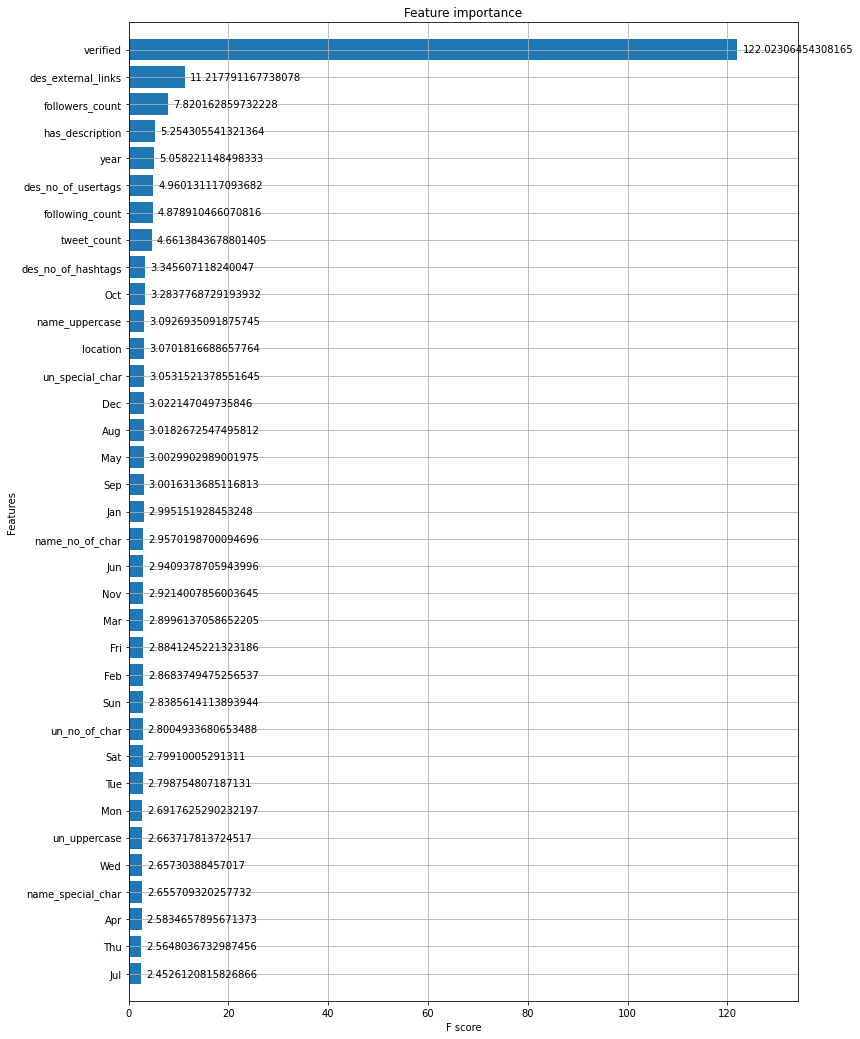

In [69]:
fig, ax = plt.subplots(figsize=(12,18))
xgb.plot_importance(xgbmodel_all_tuned, importance_type = 'gain', height=0.8, ax=ax)
plt.show()